In [1]:
import pandas as pd
import numpy as np
import os
from ebmdatalab import bq
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [2]:
# Load function definitions
%run forecasting.py

# Prototyping ARIMA forecasting for primary care prescribing data

Some stuff here about terrible forecasting.

## Set parameters before starting

In [3]:
#set dates for training data (for AutoARIMA, usually 2-3 years) 
start_forecast = '2023-10-01' # in final model this will be one month after latest available data, for testing purposes this can be changed
end_forecast = financial_year_end(start_forecast) # the end of the financial year the forecast relates to
training_months = 24 # how many months we want the AutoARIMA training model to use
start_training = start_training_date(start_forecast, training_months) #  month for the start of the training model
end_training = end_training_date(start_forecast) # end of the training model (usually the last month of data available)


# set variables for test modelling
latest_pricing_data = pd.to_datetime(start_forecast) + pd.DateOffset(months=2) # assume that pricing data is usually two months ahead of prescribing data for testing purposes - in final model this would be a function to find date of latest pricing data
horizon = 1 + (pd.to_datetime(end_forecast).year - pd.to_datetime(start_forecast).year) * 12 + (pd.to_datetime(end_forecast).month - pd.to_datetime(start_forecast).month) # calculates the number of months needed in the prediction, depending on number of months of in year data avaialble
season_length = 12 # Describe season length for AutoARIMA (months in a year in this case)
current_fy = financial_year_start(start_forecast) # Calculate start of financial year
top_x_percent = 80  # Define the top x% of BNF codes (for both items and costs) to use in individual AutoARIMA forecasting
multiplier_limit = 50 # Define limits for filtering out unexpected actual vs expected price per unit (both x and 1/x multipliers)

In [4]:
print(start_training)
print(end_training)
print(latest_pricing_data)

2021-10-01 00:00:00
2023-09-01 00:00:00
2023-12-01 00:00:00


### Step 1: Get price data

#### Step 1a: obtain Drug Tariff and price concession data

In [5]:
# define SQL for getting dt data from BigQuery
# this gets dt data, and adds price concession data where it exists for a VMPP and date.  It only gets data between the start data and end forecast variables defined above.

start_training_str = start_training.strftime('%Y-%m-%d')
end_forecast_str = end_forecast.strftime('%Y-%m-%d')

sql = f""" 
SELECT
  dt.date AS month,
  dt.vmpp AS vmpp,
  vmpp.bnf_code AS bnf_code,
  dt.price_pence AS price_pence,
  pc.price_pence AS pc_price_pence,
  dt.tariff_category AS dt_category,
  CASE
      WHEN vmpp.qty_uom = 3317411000001100 THEN 1 # where unit_of_measure is "dose" it uses 1, i.e. pack  - examples are salbutamol inhalers, where it returns 1 rather than 200
      WHEN vmpp.qty_uom = 258770004 THEN (vmpp.qtyval * 1000) # where unit_of_measure is "litre", it multiplies qtyval by 1000 to convert to mililitres, which is how EPD data is shown
      ELSE vmpp.qtyval END AS qtyval
FROM
  dmd.tariffprice AS dt
INNER JOIN
  dmd.vmpp AS vmpp
ON
  dt.vmpp = vmpp.id
LEFT OUTER JOIN
  dmd.ncsoconcession AS pc
ON
  dt.vmpp = pc.vmpp
  AND dt.date = pc.date
WHERE dt.date BETWEEN '{start_training_str}' AND '{end_forecast_str}'
"""
exportfile = os.path.join("..","data","dt_price_df.csv") # defines name for cache file
dt_raw_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False) # uses BQ if changed, otherwise csv cache file
dt_raw_df['price_per_unit'] = dt_raw_df['price_pence']/dt_raw_df['qtyval'] # create price per unit column for dt data
dt_raw_df['pc_price_per_unit'] = dt_raw_df['pc_price_pence']/dt_raw_df['qtyval'] # create price per unit column for dt data
dt_raw_df['month'] = pd.to_datetime(dt_raw_df['month']) # ensure month data is datetime format
dt_raw_df['price_per_unit'] = dt_raw_df['price_per_unit'].astype(float) # ensure ppu is in float
dt_raw_df['pc_price_per_unit'] = dt_raw_df['pc_price_per_unit'].astype(float) # ensure ppu is in float

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [6]:
dt_price_df = rank_and_filter_prices(dt_raw_df) #use function create ranking of price per unit for each BNF code (as possibly multiple VMPPs per BNF code), and create filtered df containing only the top ranked one

#### Step 1b: obtain other drug costs from dm+d

In [7]:
# define SQL for getting dm+d data from BigQuery
# this gets dm+d data, where there is an NHS indicative price listed
# unlike drug tariff data this is not a monthly price list, but has "current price", "previous price" and date of price change
sql = """
SELECT
  ampp.id AS ampp,
  ampp.bnf_code,
  priceinfo_price,
  priceinfo_pricedt,
  priceinfo_price_prev,
    CASE 
        WHEN vmpp.qty_uom = 3317411000001100 THEN 1 # as above
        WHEN vmpp.qty_uom = 258770004 THEN (vmpp.qtyval * 1000) #as above
        ELSE qtyval END AS qtyval
FROM
  `ebmdatalab.dmd.ampp_full` AS ampp
INNER JOIN
  dmd.vmpp AS vmpp
ON
  ampp.vmpp = vmpp.id
WHERE
  priceinfo_price_basis = 'NHS Indicative Price'
"""
exportfile = os.path.join("..","data","dmd_raw_df.csv") # defines name for cache file
dmd_raw_df = bq.cached_read(sql, csv_path=exportfile, use_cache=False) # uses BQ if changed, otherwise csv cache file
dmd_raw_df['priceinfo_pricedt'] = pd.to_datetime(dmd_raw_df['priceinfo_pricedt']) # convert priceinfo_pricedt to datetime
dmd_raw_df['qtyval'] = dmd_raw_df['qtyval'].astype(float)

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [8]:
# Use function to process dm+d data into a df with month and bnf_code data, only having one row for each bnf_code and month
dmd_price_df = process_dmd_data(dmd_raw_df, start_training, end_forecast) 

#### Step 1c: merge data into single dataframe

In [9]:
# use function to merge dm+d codes (which are not already included in dt) into dt df to create single list of prices
full_price_df = merge_and_update_prices(dmd_price_df, dt_price_df) 

#open NADP file (for <2024-04-01 usage) and adjust prices to actual_cost using nadp_adjuster function
nadp_df = pd.read_csv(os.path.join("..","data","nadp_data.csv"))
nadp_df['month'] = pd.to_datetime(nadp_df['month'])
nadp_adjuster(full_price_df, nadp_df)

#remove all items with zero cost
full_price_df = full_price_df[full_price_df['price_per_unit'] != 0]

#create list of BNF codes for processing prescribing data lat
full_price_bnf_codes = full_price_df[['bnf_code']].drop_duplicates()

We've now got a single monthly price list for all DT and dm+d items, where there is a price against the item

### Step 2: get prescribing data

In [10]:
start_training_str = start_training.strftime('%Y-%m-%d')
end_forecast_str = end_forecast.strftime('%Y-%m-%d')
sql = f"""
SELECT DATE(month) AS month,
       bnf_name,
       bnf_code,
       SUM(quantity) AS quantity,
       SUM(items) AS items,
       SUM(actual_cost) AS actual_cost
FROM   hscic.normalised_prescribing 
WHERE  month BETWEEN '{start_training}' AND '{end_forecast}'
GROUP BY month,
          bnf_code,
          bnf_name 
"""

exportfile = os.path.join("..","data","rx_df.csv") #defines name for cache file
rx_df = bq.cached_read(sql, csv_path=exportfile, use_cache=True) #uses BQ if changed, otherwise csv cache file
rx_df['month'] = pd.to_datetime(rx_df['month']) #ensure dates are in datetimeformat

### Step 3: process data for forecasting

### Find top x, remove zero cost and multiplier limits

In [11]:
topx_rx_df, non_topx_rx_df = create_arima_bnf_codes(rx_df, full_price_df, full_price_bnf_codes, current_fy, end_training, top_x_percent, multiplier_limit)

Number of BNF codes in top 80% items or spend: 1350


### Step 3c: create dataframe for use with ARIMA forecasting tool

In [12]:
# create df for use with statsforecast, having only neccesary columns and named correctly
arima_top_df = topx_rx_df[['month', 'bnf_code', 'quantity']].copy()

# Rename columns to fit statsforecast
arima_top_df.rename(columns={
    'month': 'ds',
    'bnf_code': 'unique_id',
    'quantity': 'y'
}, inplace=True)

### Step 5: Create dataframe and variables for testing at various points in financial year

In [13]:
filtered_arima_df = arima_top_df[(arima_top_df['ds'] >= start_training) & (arima_top_df['ds'] <= end_training)].sort_values(by=['ds','unique_id']) # creates testing model of prescribing data with modelling for various points in the year
training_arima_df = fill_missing_combinations(filtered_arima_df, start_training, end_training) #ensure really seasonal data (e.g. flu vaccines) have 0 in other months **CHANGED TO DO PREDICTION*
training_arima_df['ds'] = pd.to_datetime(training_arima_df['ds'])

In [14]:
training_arima_df.dtypes

ds           datetime64[ns]
unique_id            object
y                   float64
dtype: object

In [15]:
# Run AutoARIMA function
forecast_rx_top_df = forecast_prescribing_data(training_arima_df, topx_rx_df, start_training, end_training, horizon, season_length)

In [16]:
#filter full_price df to reflect data available at time of forecasting - assume 2 months ahead of prescribing data
filtered_full_price_df = full_price_df[
    (full_price_df['month'] <= latest_pricing_data) #&
    #(full_price_df['bnf_code'].isin(top_bnf_codes))
]

# add latest available data through to each month to end of forecast
final_price_df = fill_missing_dates(filtered_full_price_df, end_forecast)

In [17]:
costed_forecast_rx_df = pd.merge(forecast_rx_top_df, final_price_df, left_on = ['ds', 'unique_id'], right_on=['month', 'bnf_code'], how='outer', indicator=True) # merge to get prices

In [18]:
# Calculate predicted costs

costed_forecast_rx_df['predicted_cost'] = costed_forecast_rx_df['AutoARIMA'] * (costed_forecast_rx_df['pc_price_per_unit'].fillna(costed_forecast_rx_df['price_per_unit']))/100
costed_forecast_rx_df['predicted_cost-lo-95'] = costed_forecast_rx_df['AutoARIMA-lo-95'] * (costed_forecast_rx_df['pc_price_per_unit'].fillna(costed_forecast_rx_df['price_per_unit']))/100
costed_forecast_rx_df['predicted_cost-hi-95'] = costed_forecast_rx_df['AutoARIMA-hi-95'] * (costed_forecast_rx_df['pc_price_per_unit'].fillna(costed_forecast_rx_df['price_per_unit']))/100

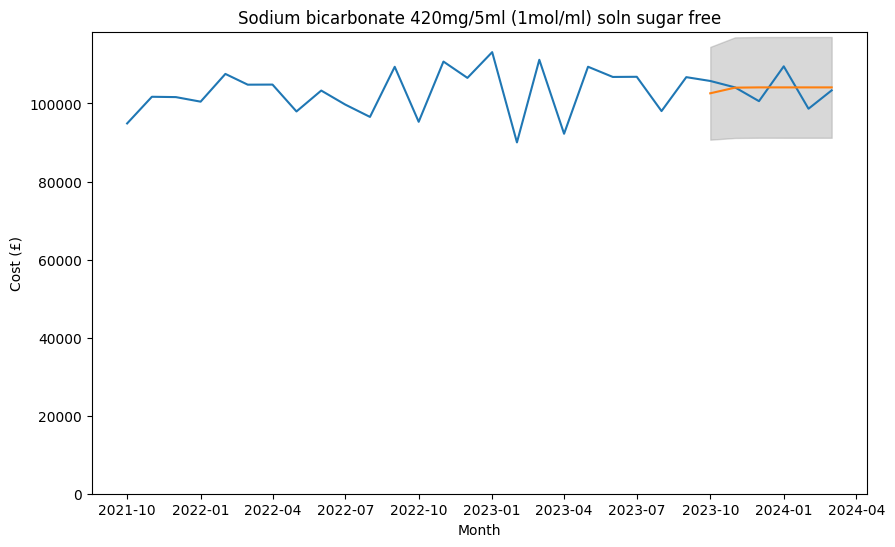

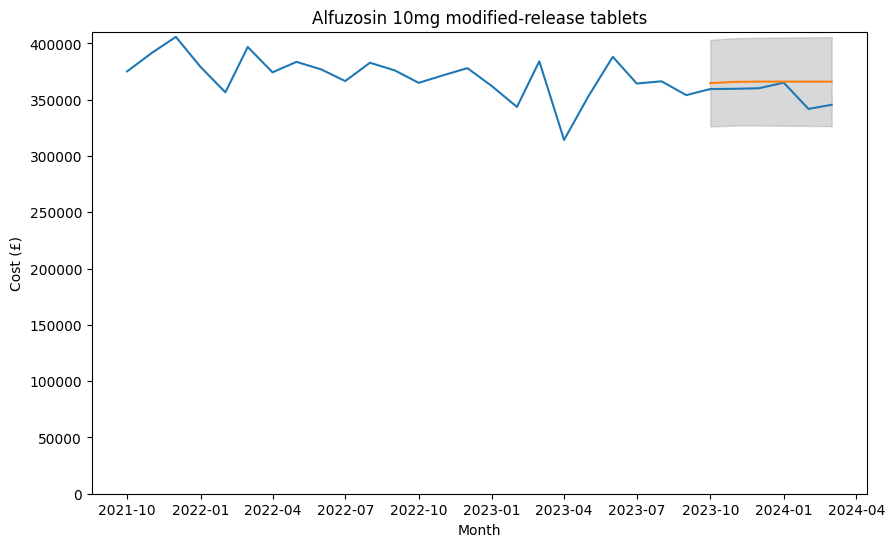

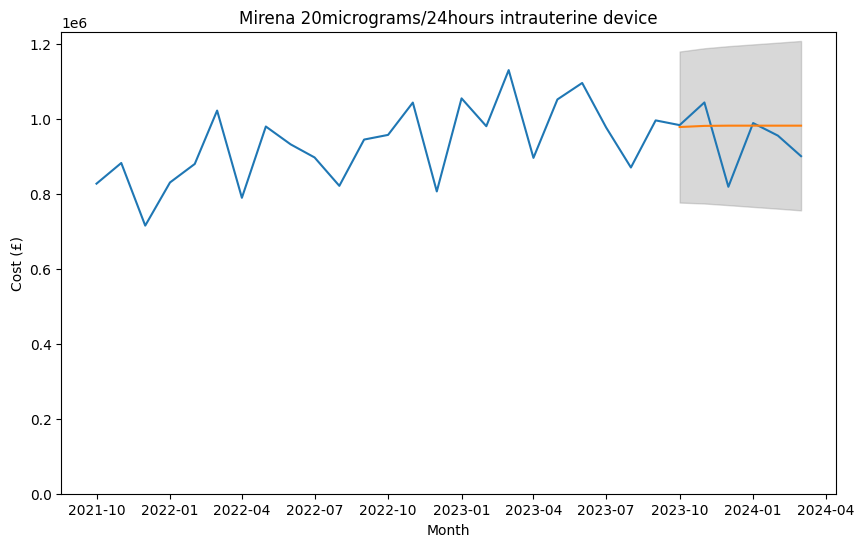

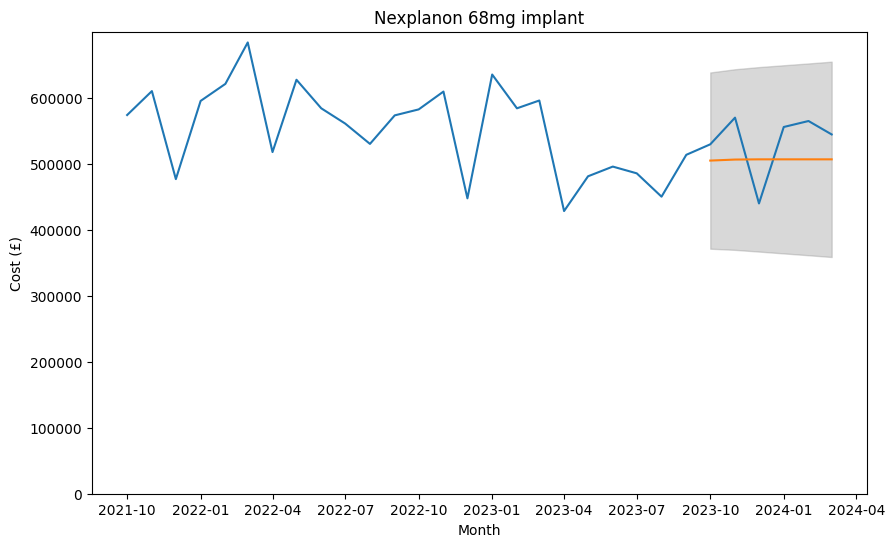

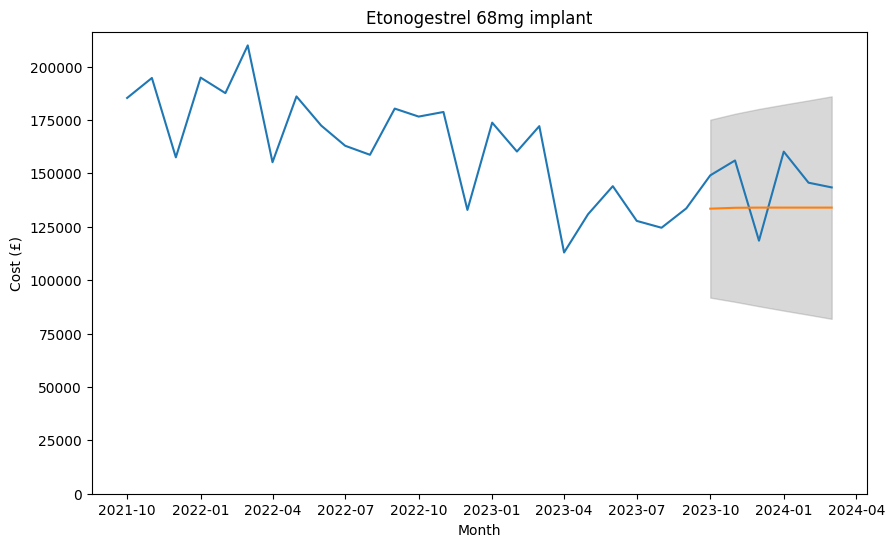

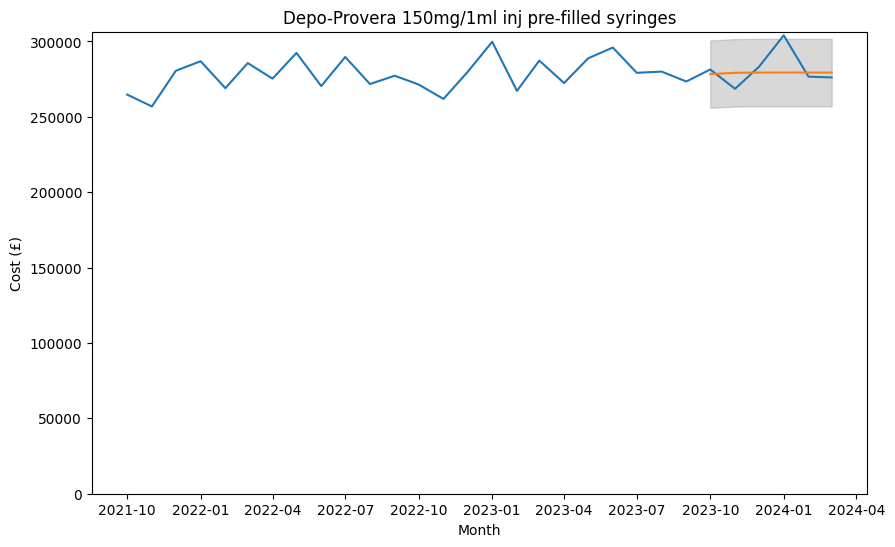

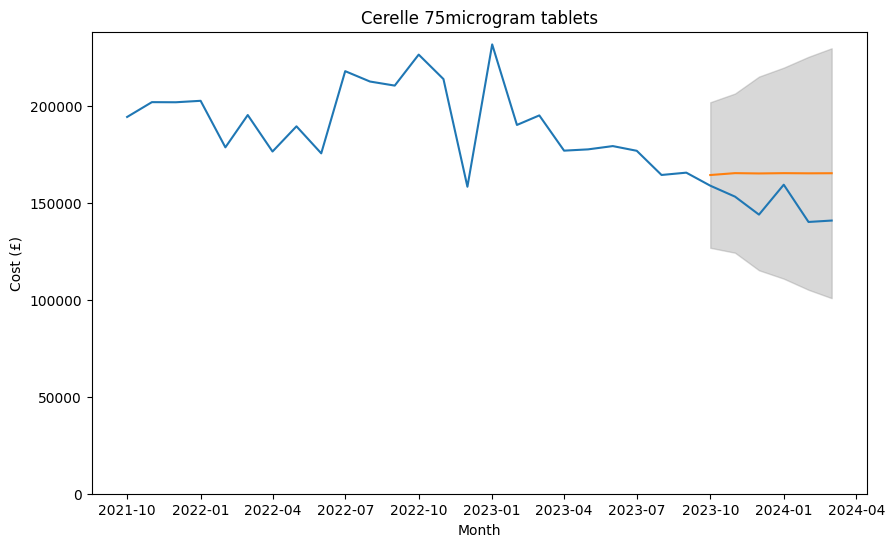

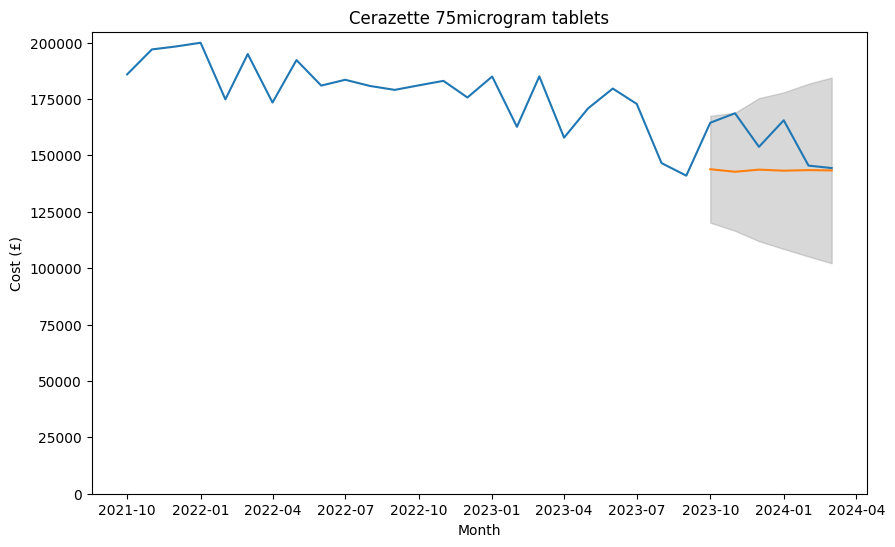

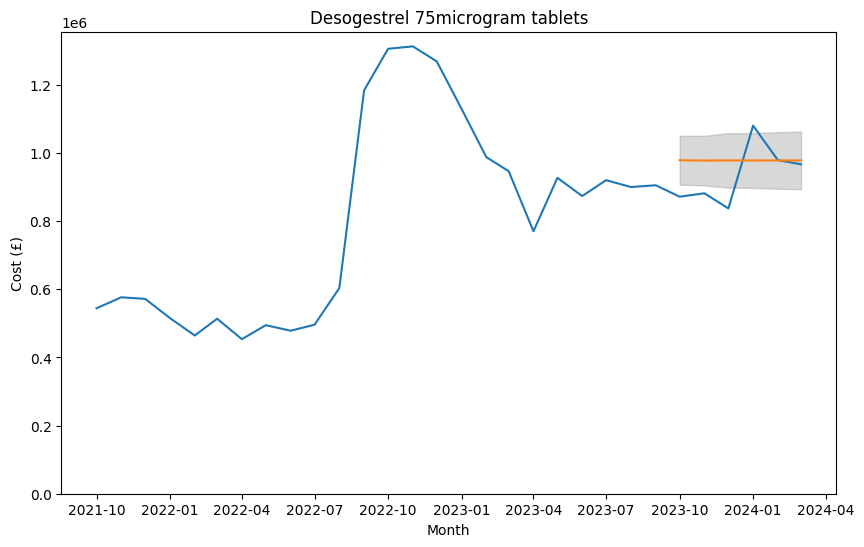

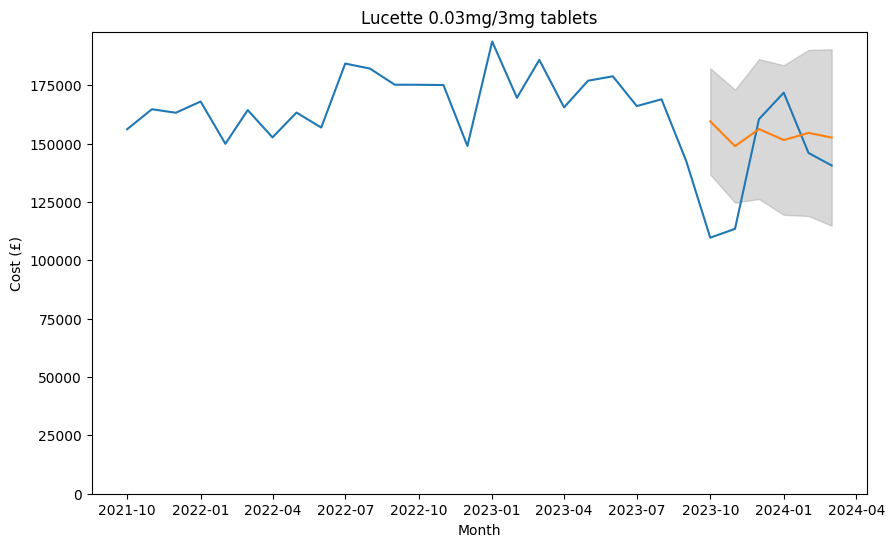

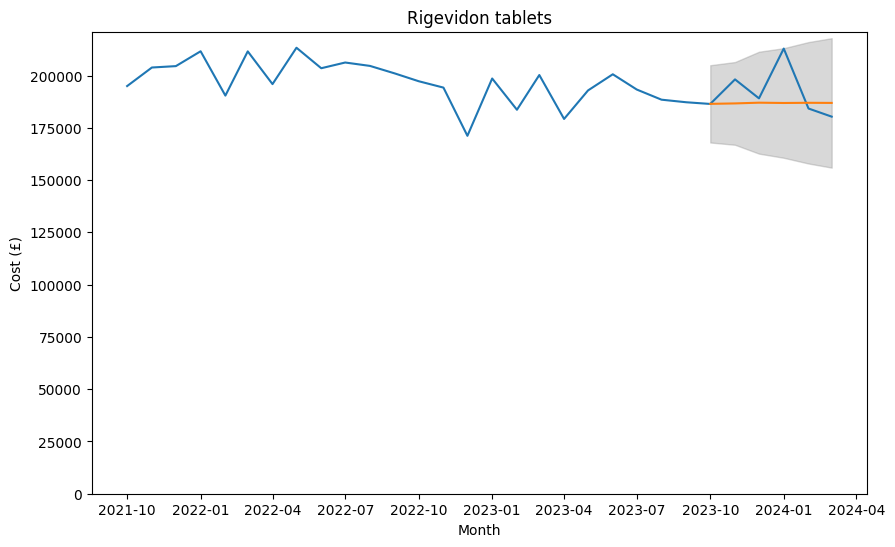

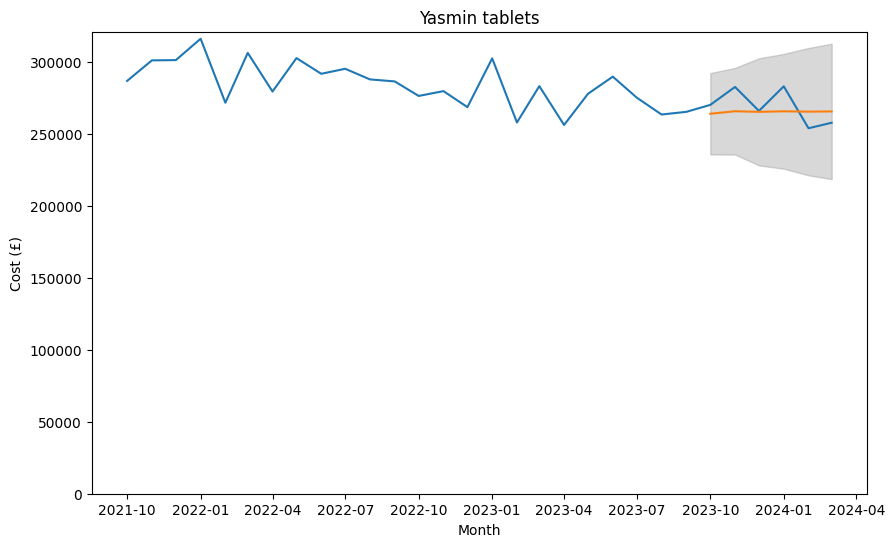

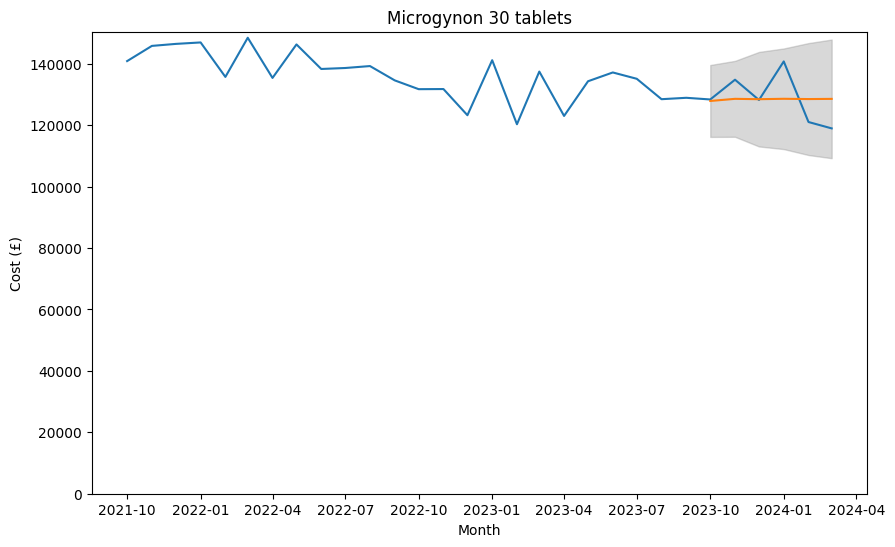

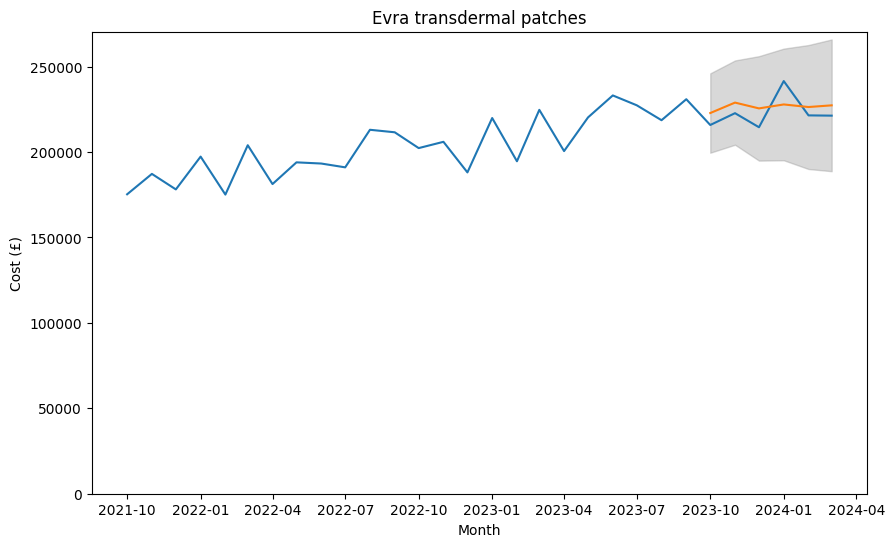

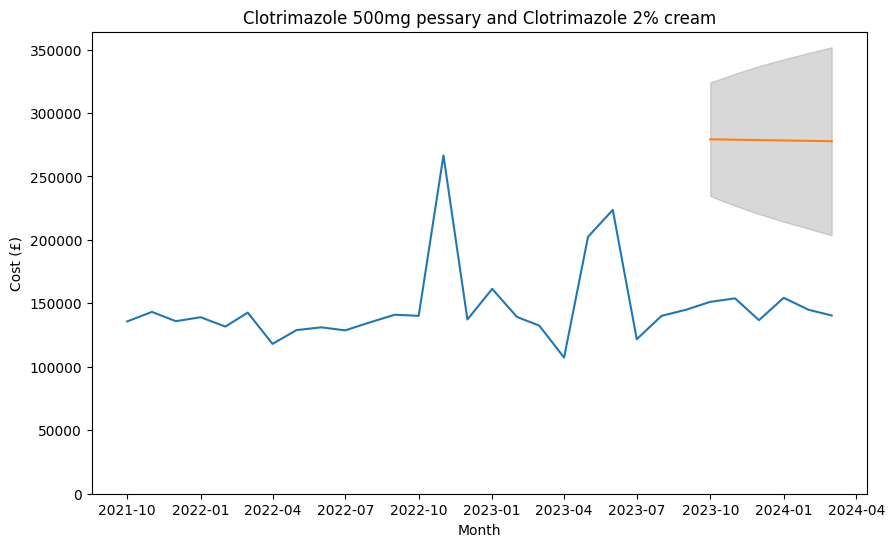

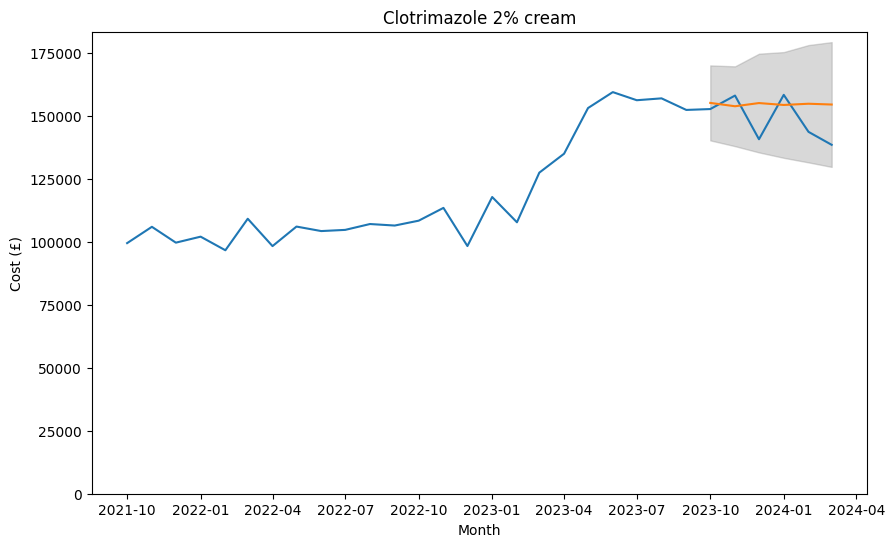

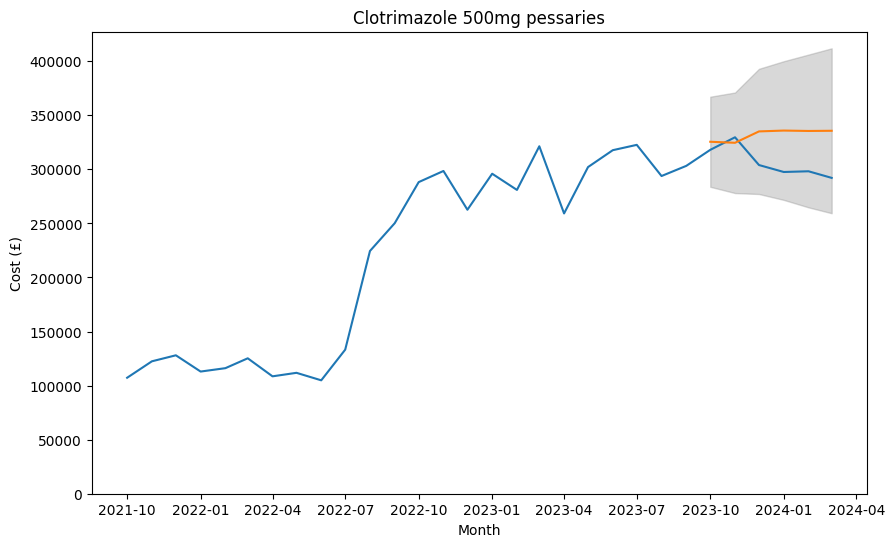

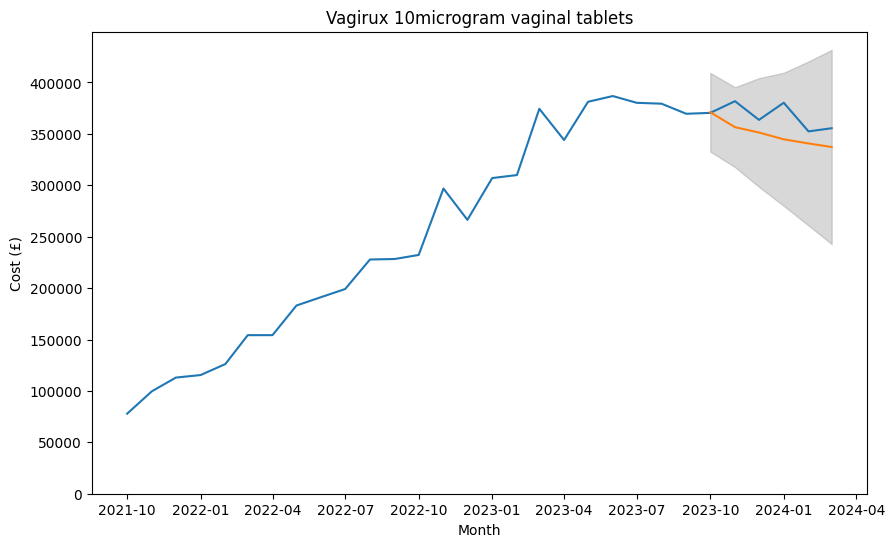

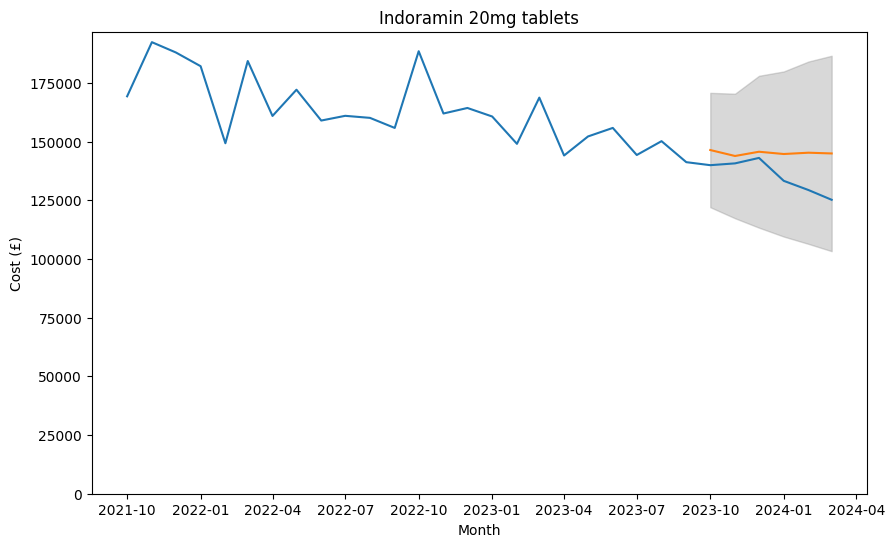

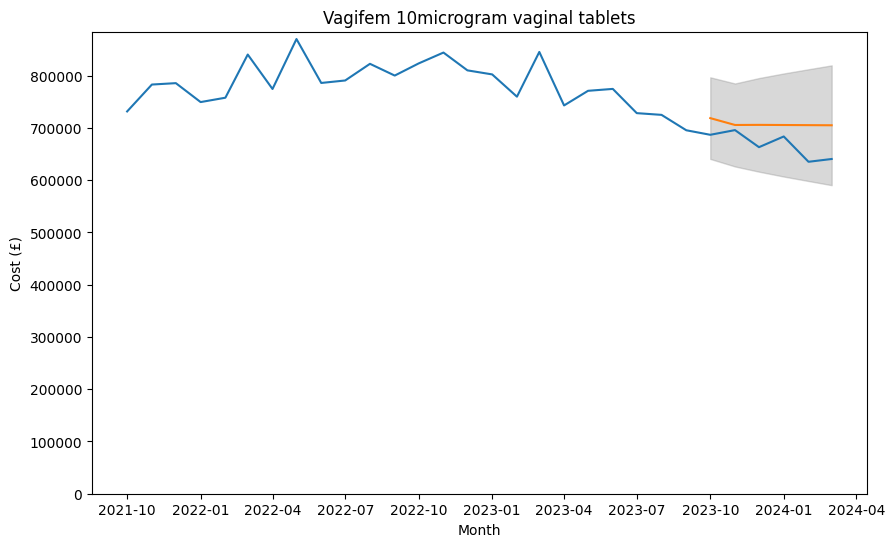

In [19]:
#######TESTING TO DRAW QUANTITY ARIMA CHARTS############
unique_bnf_codes =  costed_forecast_rx_df['bnf_code_x'].unique()
first_x_bnf_codes = unique_bnf_codes[:20]

for code in first_x_bnf_codes:
    # Filter the DataFrame for the current bnf_code
    filtered_df = costed_forecast_rx_df[costed_forecast_rx_df['bnf_code_x'] == code]

    # Get the corresponding bnf_name (assuming it's the same for all rows with this bnf_code_x)
    bnf_name = filtered_df['bnf_name'].iloc[0]  # Using .iloc[0] to get the first instance of the bnf_name
   
    # Plot month vs items
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['month_x'], filtered_df['actual_cost'])
    plt.plot(filtered_df['month_x'], filtered_df['predicted_cost'])
    plt.fill_between(filtered_df['month_x'], filtered_df['predicted_cost-lo-95'], filtered_df['predicted_cost-hi-95'], color='gray', alpha=0.3, label='95% CI')
    
    # Set the title to the bnf_name
    plt.title(bnf_name)
    plt.ylim(bottom=0)
    
    # Label the axes
    plt.xlabel('Month')
    plt.ylabel('Cost (£)')
    
    # Show the plot
    plt.show()

In [20]:
# look at cumulative costs

grouped_df = costed_forecast_rx_df.groupby('month_x')[['actual_cost', 'predicted_cost', 'predicted_cost-lo-95', 'predicted_cost-hi-95']].sum().reset_index()
grouped_df.replace(0, np.nan, inplace=True)
grouped_df = grouped_df[
    (grouped_df['month_x'] >= '2023-04-01')]

#fill the NAs in the predicted costs with the actual costs, to allow us to plot it
grouped_df['predicted_cost'] = grouped_df['predicted_cost'].fillna(grouped_df['actual_cost'])
grouped_df['predicted_cost-lo-95'] = grouped_df['predicted_cost-lo-95'].fillna(grouped_df['actual_cost'])
grouped_df['predicted_cost-hi-95'] = grouped_df['predicted_cost-hi-95'].fillna(grouped_df['actual_cost'])

#make a cumulative sum version
cumsum_grouped_df = grouped_df.copy()
cumsum_grouped_df[['actual_cost', 'predicted_cost', 'predicted_cost-lo-95', 'predicted_cost-hi-95']] = cumsum_grouped_df[['actual_cost', 'predicted_cost', 'predicted_cost-lo-95', 'predicted_cost-hi-95']].cumsum()

In [41]:
print(grouped_df)

      month_x   actual_cost  predicted_cost  predicted_cost-lo-95  \
18 2023-04-01  6.335815e+08    6.335815e+08          6.335815e+08   
19 2023-05-01  6.853704e+08    6.853704e+08          6.853704e+08   
20 2023-06-01  7.009336e+08    7.009336e+08          7.009336e+08   
21 2023-07-01  6.752341e+08    6.752341e+08          6.752341e+08   
22 2023-08-01  6.845514e+08    6.845514e+08          6.845514e+08   
23 2023-09-01  7.039632e+08    7.039632e+08          7.039632e+08   
24 2023-10-01  7.023310e+08    7.000229e+08          5.892476e+08   
25 2023-11-01  6.784638e+08    6.938378e+08          5.584313e+08   
26 2023-12-01  6.742392e+08    6.909226e+08          5.334779e+08   
27 2024-01-01  6.779075e+08    6.887869e+08          5.137521e+08   
28 2024-02-01  6.357250e+08    6.876169e+08          4.961116e+08   
29 2024-03-01  6.454199e+08    6.871628e+08          4.804593e+08   

    predicted_cost-hi-95  
18          6.335815e+08  
19          6.853704e+08  
20          7.009336e

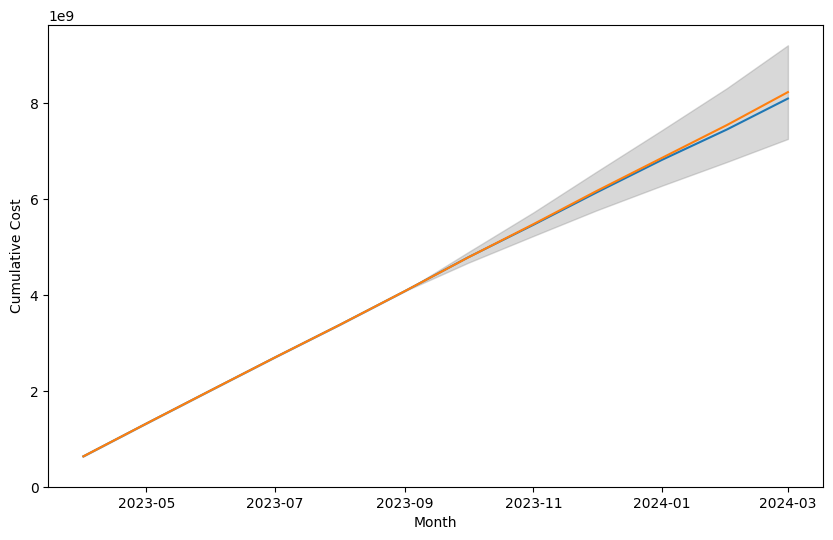

In [22]:
# plot the data

plt.figure(figsize=(10, 6))
plt.plot(cumsum_grouped_df['month_x'], cumsum_grouped_df['actual_cost'])
plt.plot(cumsum_grouped_df['month_x'], cumsum_grouped_df['predicted_cost'])
plt.fill_between(cumsum_grouped_df['month_x'], cumsum_grouped_df['predicted_cost-lo-95'], cumsum_grouped_df['predicted_cost-hi-95'], color='gray', alpha=0.3, label='95% CI')
    
    # Set the title to the bnf_name
    #plt.title(bnf_name)
plt.ylim(bottom=0)
    
    # Label the axes
plt.xlabel('Month')
plt.ylabel('Cumulative Cost')
    
    # Show the plot
plt.show()

## part 4  - other ARIMA forecasting

Take the remaining x percent, and do a single AutoARIMA on it.

In [23]:
non_topx_rx_df.head()

,month,bnf_name,bnf_code,quantity,items,actual_cost
4,2022-08-01,Beclometasone 200microg/Formoterol 6microg/dos...,0302000C0AABZBZ,3698.0,3127,101364.90595
5,2022-08-01,Aquacel Extra dressing 5cm x 5cm square,20031700075,30445.0,2244,29889.86975
6,2022-08-01,Valsartan 80mg capsules,0205052V0AAABAB,414058.0,10137,73229.15016
7,2022-08-01,Chlordiazepoxide 5mg capsules,0401020E0AAADAD,78001.0,1686,12335.62106
9,2022-08-01,Dalivit oral drops,090607000BBAZAG,226225.0,6849,52868.02412


In [24]:
non_top_arima_rx_df = non_topx_rx_df.groupby('month')['actual_cost'].sum().reset_index()

In [25]:
# Rename columns to fit statsforecast
non_top_arima_rx_df['unique_id'] = '999999999999999'
non_top_arima_rx_df.rename(columns={
    'month': 'ds',
    'actual_cost': 'y'
}, inplace=True)

In [26]:
filtered_non_top_arima_rx_df = non_top_arima_rx_df[(non_top_arima_rx_df['ds'] >= start_training) & (non_top_arima_rx_df['ds'] <= end_training)].sort_values(by=['ds','unique_id']) # creates testing model of prescribing data with modelling for various points in the year

In [27]:
# create statsforecast model
os.environ['NIXTLA_ID_AS_COL'] = '1'
season_length = 12 # Monthly data 
models = [AutoARIMA(season_length=season_length)] # set AutoARIMA as model
sf = StatsForecast(models=models,
                   freq='MS', #frequency start of month
                   n_jobs=-1) # use all processors

forecast_non_top_rx_df = sf.forecast(df=filtered_non_top_arima_rx_df, h=horizon, level=[95])


In [28]:
forecast_non_top_rx_df.head(12)

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,999999999999999,2023-10-01,161024368.0,147799104.0,174249632.0
1,999999999999999,2023-11-01,161022288.0,147693488.0,174351104.0
2,999999999999999,2023-12-01,161020208.0,147588656.0,174451776.0
3,999999999999999,2024-01-01,161018144.0,147484624.0,174551664.0
4,999999999999999,2024-02-01,161016064.0,147381344.0,174650784.0
5,999999999999999,2024-03-01,161013984.0,147278816.0,174749152.0


In [29]:
full_forecast_non_top_rx_df = pd.merge(non_top_arima_rx_df, forecast_non_top_rx_df, left_on=['ds'], right_on=['ds'], how='outer').sort_values(by=['ds'])

In [43]:

filtered_forecast_non_top_rx_df = full_forecast_non_top_rx_df[
    (full_forecast_non_top_rx_df['ds'] >= '2023-04-01')]

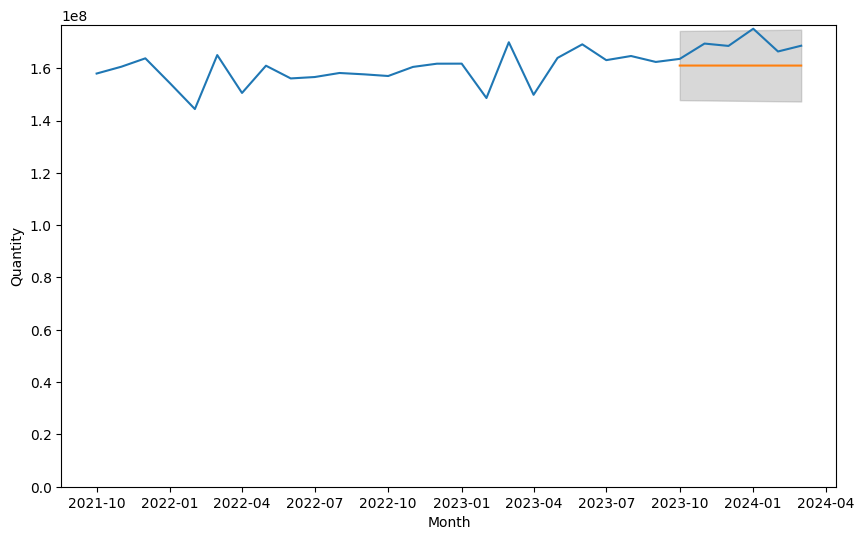

In [31]:
# Plot month vs items
plt.figure(figsize=(10, 6))
plt.plot(full_forecast_non_top_rx_df['ds'], full_forecast_non_top_rx_df['y'])
#plt.plot(filtered_df['month'], filtered_df['AutoETS'])
#plt.fill_between(filtered_df['month'], filtered_df['AutoETS-lo-95'], filtered_df['AutoETS-hi-95'], color='gray', alpha=0.3, label='95% CI')
plt.plot(full_forecast_non_top_rx_df['ds'], full_forecast_non_top_rx_df['AutoARIMA'])
plt.fill_between(full_forecast_non_top_rx_df['ds'], full_forecast_non_top_rx_df['AutoARIMA-lo-95'], full_forecast_non_top_rx_df['AutoARIMA-hi-95'], color='gray', alpha=0.3, label='95% CI')

# Set the title to the bnf_name
#plt.title(bnf_name)
plt.ylim(bottom=0)

# Label the axes
plt.xlabel('Month')
plt.ylabel('Quantity')

# Show the plot
plt.show()

## Finalise data

In [42]:
grouped_df.head()

,month_x,actual_cost,predicted_cost,predicted_cost-lo-95,predicted_cost-hi-95
18,2023-04-01,6.335815e+08,6.335815e+08,6.335815e+08,6.335815e+08
19,2023-05-01,6.853704e+08,6.853704e+08,6.853704e+08,6.853704e+08
20,2023-06-01,7.009336e+08,7.009336e+08,7.009336e+08,7.009336e+08
21,2023-07-01,6.752341e+08,6.752341e+08,6.752341e+08,6.752341e+08
22,2023-08-01,6.845514e+08,6.845514e+08,6.845514e+08,6.845514e+08


In [48]:
filtered_forecast_non_top_rx_df.head(12)

,ds,y,unique_id_x,unique_id_y,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
18,2023-04-01,1.498417e+08,999999999999999,NaN,NaN,NaN,NaN
19,2023-05-01,1.639464e+08,999999999999999,NaN,NaN,NaN,NaN
20,2023-06-01,1.691314e+08,999999999999999,NaN,NaN,NaN,NaN
21,2023-07-01,1.630916e+08,999999999999999,NaN,NaN,NaN,NaN
22,2023-08-01,1.646725e+08,999999999999999,NaN,NaN,NaN,NaN
23,2023-09-01,1.624014e+08,999999999999999,NaN,NaN,NaN,NaN
24,2023-10-01,1.635743e+08,999999999999999,999999999999999,161024368.0,147799104.0,174249632.0
25,2023-11-01,1.694250e+08,999999999999999,999999999999999,161022288.0,147693488.0,174351104.0
26,2023-12-01,1.685285e+08,999999999999999,999999999999999,161020208.0,147588656.0,174451776.0
27,2024-01-01,1.750977e+08,999999999999999,999999999999999,161018144.0,147484624.0,174551664.0


In [46]:
final_df = pd.merge(grouped_df, filtered_forecast_non_top_rx_df, left_on='month_x', right_on='ds', suffixes=('_df1', '_df2'))


In [56]:
final_df.head(12)

,month_x,actual_cost,predicted_cost,predicted_cost-lo-95,predicted_cost-hi-95,ds,y,unique_id_x,unique_id_y,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,total_actual_cost,forecasted_cost,forecasted_95_lo,forecasted_95_hi
0,2023-04-01,6.335815e+08,6.335815e+08,6.335815e+08,6.335815e+08,2023-04-01,1.498417e+08,999999999999999,NaN,NaN,NaN,NaN,7.834232e+08,NaN,NaN,NaN
1,2023-05-01,6.853704e+08,6.853704e+08,6.853704e+08,6.853704e+08,2023-05-01,1.639464e+08,999999999999999,NaN,NaN,NaN,NaN,8.493168e+08,NaN,NaN,NaN
2,2023-06-01,7.009336e+08,7.009336e+08,7.009336e+08,7.009336e+08,2023-06-01,1.691314e+08,999999999999999,NaN,NaN,NaN,NaN,8.700651e+08,NaN,NaN,NaN
3,2023-07-01,6.752341e+08,6.752341e+08,6.752341e+08,6.752341e+08,2023-07-01,1.630916e+08,999999999999999,NaN,NaN,NaN,NaN,8.383257e+08,NaN,NaN,NaN
4,2023-08-01,6.845514e+08,6.845514e+08,6.845514e+08,6.845514e+08,2023-08-01,1.646725e+08,999999999999999,NaN,NaN,NaN,NaN,8.492239e+08,NaN,NaN,NaN
5,2023-09-01,7.039632e+08,7.039632e+08,7.039632e+08,7.039632e+08,2023-09-01,1.624014e+08,999999999999999,NaN,NaN,NaN,NaN,8.663646e+08,NaN,NaN,NaN
6,2023-10-01,7.023310e+08,7.000229e+08,5.892476e+08,8.107981e+08,2023-10-01,1.635743e+08,999999999999999,999999999999999,161024368.0,147799104.0,174249632.0,8.659053e+08,8.610472e+08,7.370467e+08,9.850478e+08
7,2023-11-01,6.784638e+08,6.938378e+08,5.584313e+08,8.292443e+08,2023-11-01,1.694250e+08,999999999999999,999999999999999,161022288.0,147693488.0,174351104.0,8.478887e+08,8.548601e+08,7.061248e+08,1.003595e+09
8,2023-12-01,6.742392e+08,6.909226e+08,5.334779e+08,8.483673e+08,2023-12-01,1.685285e+08,999999999999999,999999999999999,161020208.0,147588656.0,174451776.0,8.427677e+08,8.519428e+08,6.810666e+08,1.022819e+09
9,2024-01-01,6.779075e+08,6.887869e+08,5.137521e+08,8.638216e+08,2024-01-01,1.750977e+08,999999999999999,999999999999999,161018144.0,147484624.0,174551664.0,8.530053e+08,8.498050e+08,6.612368e+08,1.038373e+09


In [77]:
final_df['total_actual_cost'] = (final_df['actual_cost'] + final_df['y'])
final_df['forecasted_cost'] = (final_df['predicted_cost'] + final_df['AutoARIMA']).fillna(final_df['total_actual_cost'])
final_df['forecasted_95_lo'] = (final_df['predicted_cost-lo-95'] + final_df['AutoARIMA-lo-95']).fillna(final_df['total_actual_cost'])
final_df['forecasted_95_hi'] = (final_df['predicted_cost-hi-95'] + final_df['AutoARIMA-hi-95']).fillna(final_df['total_actual_cost'])

In [78]:
final_predicted_df = final_df[['month_x', 'total_actual_cost','forecasted_cost','forecasted_95_lo','forecasted_95_hi']].copy()
#final_cumsum_predicted_df = final_predicted_df.groupby('month_x')[['total_actual_cost','forecasted_cost','forecasted_95_lo','forecasted_95_hi']].cumsum()
#final_cumsum_predicted_df['month_x'] = final_predicted_df['month_x']

In [79]:
final_predicted_df[['actual_cost', 'predicted_cost', 'predicted_cost-lo-95', 'predicted_cost-hi-95']] = final_predicted_df[['total_actual_cost', 'forecasted_cost', 'forecasted_95_lo', 'forecasted_95_hi']].cumsum()

In [80]:
final_predicted_df.head(12)

,month_x,total_actual_cost,forecasted_cost,forecasted_95_lo,forecasted_95_hi,actual_cost,predicted_cost,predicted_cost-lo-95,predicted_cost-hi-95
0,2023-04-01,7.834232e+08,7.834232e+08,7.834232e+08,7.834232e+08,7.834232e+08,7.834232e+08,7.834232e+08,7.834232e+08
1,2023-05-01,8.493168e+08,8.493168e+08,8.493168e+08,8.493168e+08,1.632740e+09,1.632740e+09,1.632740e+09,1.632740e+09
2,2023-06-01,8.700651e+08,8.700651e+08,8.700651e+08,8.700651e+08,2.502805e+09,2.502805e+09,2.502805e+09,2.502805e+09
3,2023-07-01,8.383257e+08,8.383257e+08,8.383257e+08,8.383257e+08,3.341131e+09,3.341131e+09,3.341131e+09,3.341131e+09
4,2023-08-01,8.492239e+08,8.492239e+08,8.492239e+08,8.492239e+08,4.190355e+09,4.190355e+09,4.190355e+09,4.190355e+09
5,2023-09-01,8.663646e+08,8.663646e+08,8.663646e+08,8.663646e+08,5.056719e+09,5.056719e+09,5.056719e+09,5.056719e+09
6,2023-10-01,8.659053e+08,8.610472e+08,7.370467e+08,9.850478e+08,5.922625e+09,5.917766e+09,5.793766e+09,6.041767e+09
7,2023-11-01,8.478887e+08,8.548601e+08,7.061248e+08,1.003595e+09,6.770513e+09,6.772627e+09,6.499891e+09,7.045362e+09
8,2023-12-01,8.427677e+08,8.519428e+08,6.810666e+08,1.022819e+09,7.613281e+09,7.624569e+09,7.180957e+09,8.068181e+09
9,2024-01-01,8.530053e+08,8.498050e+08,6.612368e+08,1.038373e+09,8.466286e+09,8.474374e+09,7.842194e+09,9.106555e+09


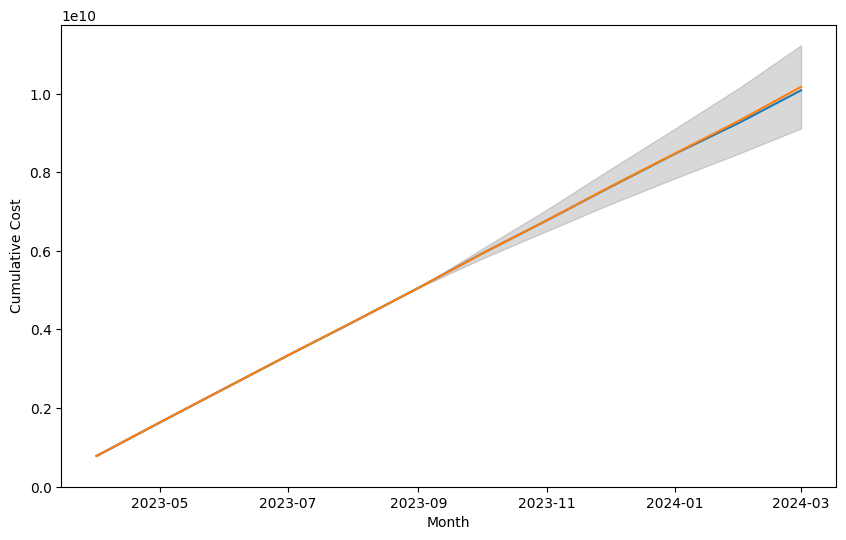

In [81]:
# plot the data

plt.figure(figsize=(10, 6))
plt.plot(final_predicted_df['month_x'], final_predicted_df['actual_cost'])
plt.plot(final_predicted_df['month_x'], final_predicted_df['predicted_cost'])
plt.fill_between(final_predicted_df['month_x'], final_predicted_df['predicted_cost-lo-95'], final_predicted_df['predicted_cost-hi-95'], color='gray', alpha=0.3, label='95% CI')
    
    # Set the title to the bnf_name
    #plt.title(bnf_name)
plt.ylim(bottom=0)
    
    # Label the axes
plt.xlabel('Month')
plt.ylabel('Cumulative Cost')
    
    # Show the plot
plt.show()